In [1]:
# Load libraries
import numpy as np
import pandas as pd
import scanpy as sc

In [2]:
# verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.verbosity = 3             
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.22.2 scipy==1.7.3 pandas==1.4.3 scikit-learn==1.1.2 statsmodels==0.13.2 python-igraph==0.9.11 pynndescent==0.5.7


In [3]:
# the file that will store the analysis results
results_file = 'pbmc3k.h5ad'  

In [4]:
adata = sc.read_10x_mtx(
    'filtered_gene_bc_matrices/hg19/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

... reading from cache file cache/filtered_gene_bc_matrices-hg19-matrix.h5ad


In [5]:
# this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`
adata.var_names_make_unique()  
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

### Preporcessing


normalizing counts per cell
    finished (0:00:00)


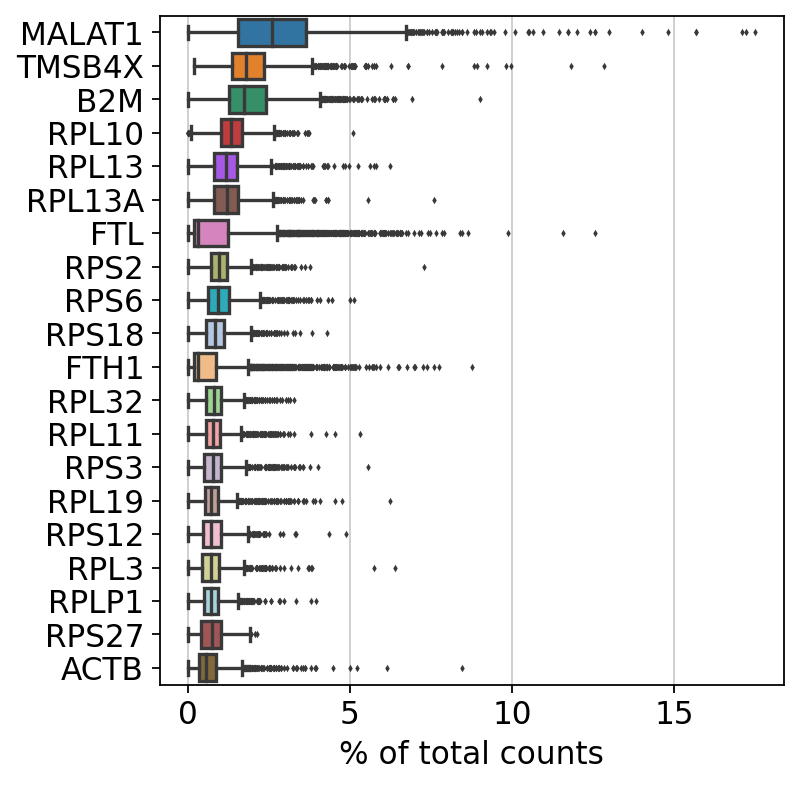

In [6]:
sc.pl.highest_expr_genes(adata, n_top=20, )

In [7]:
# basic filtering to remove low quality cells
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 19024 genes that are detected in less than 3 cells


In [8]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

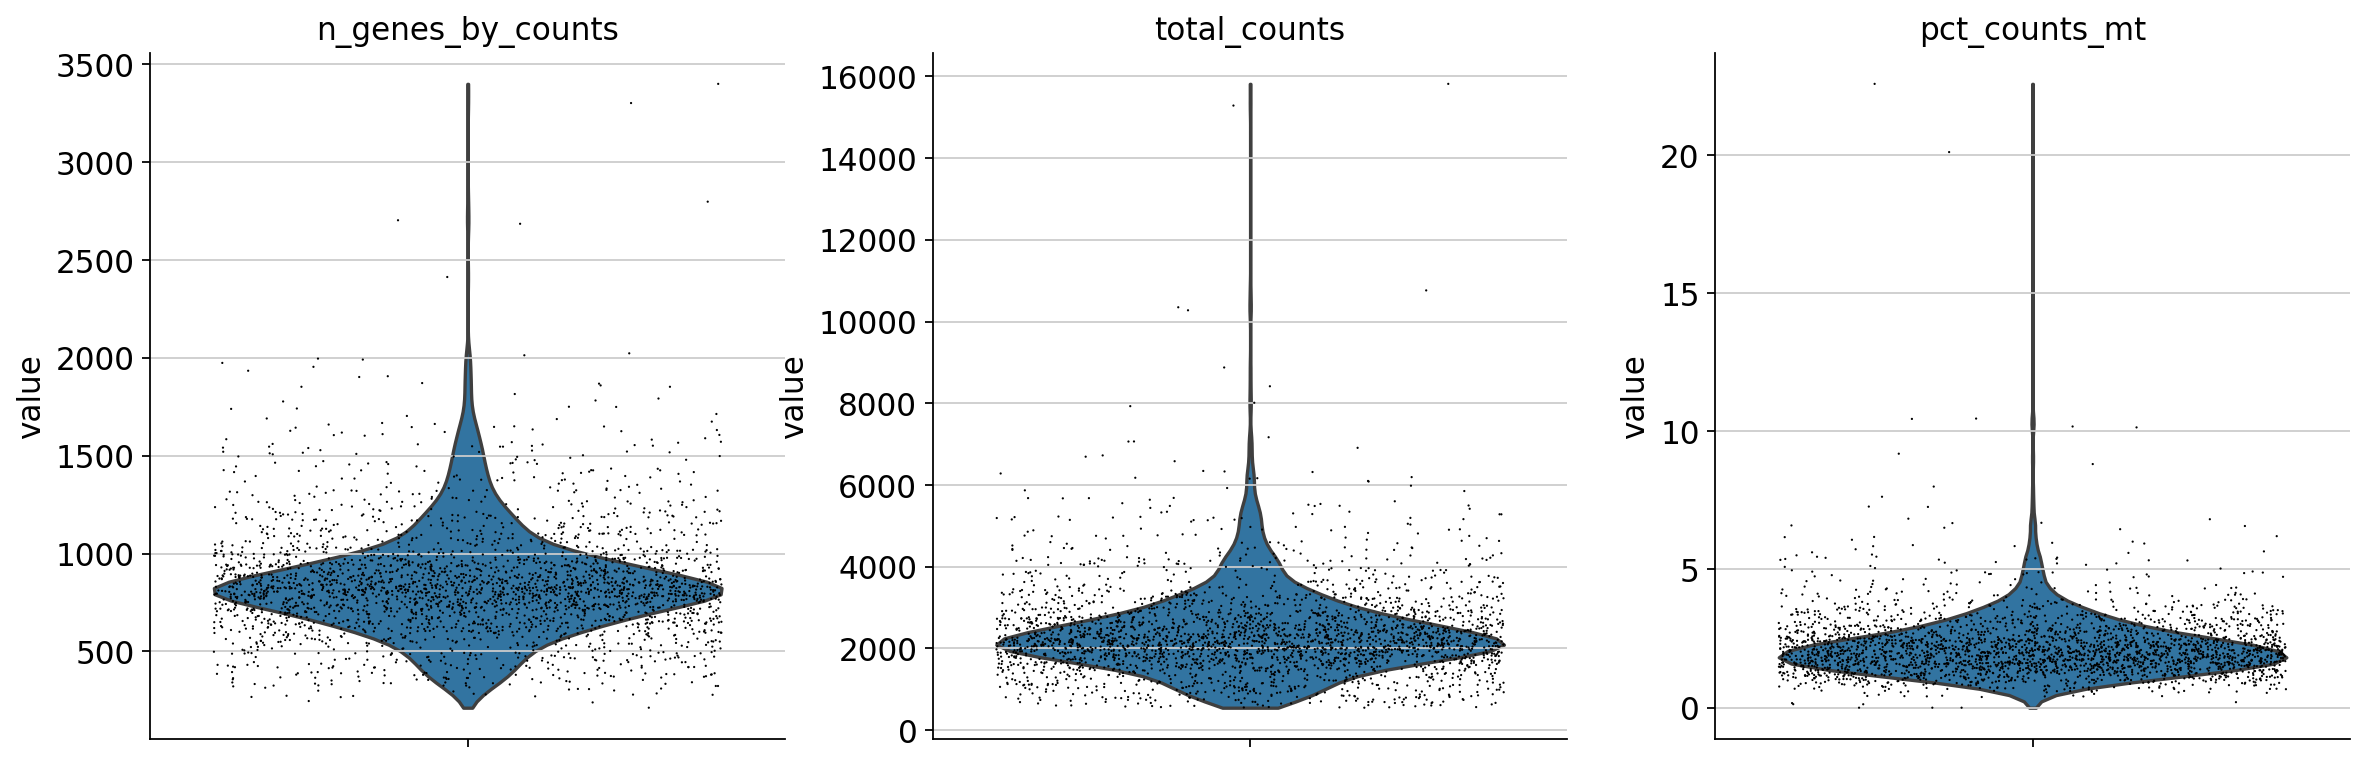

In [9]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

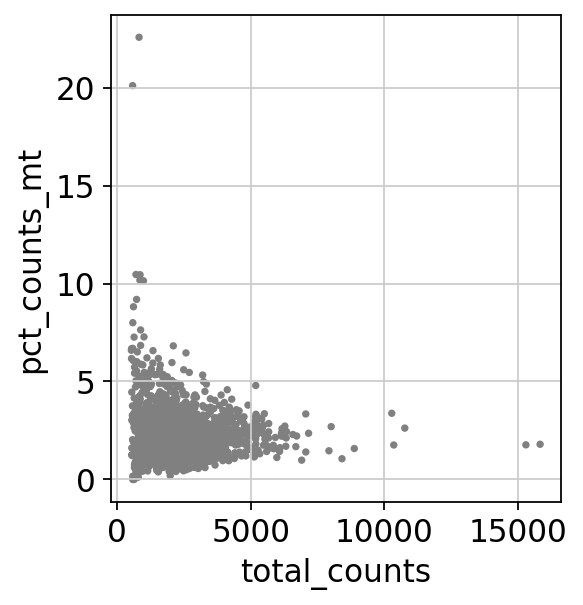

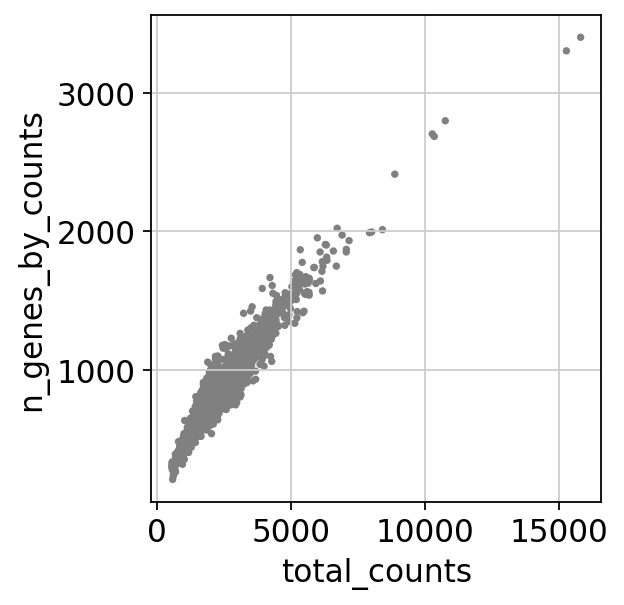

In [10]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [11]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

In [12]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


/opt/conda/envs/scGen/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [13]:
# Logarithmize the data
sc.pp.log1p(adata)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


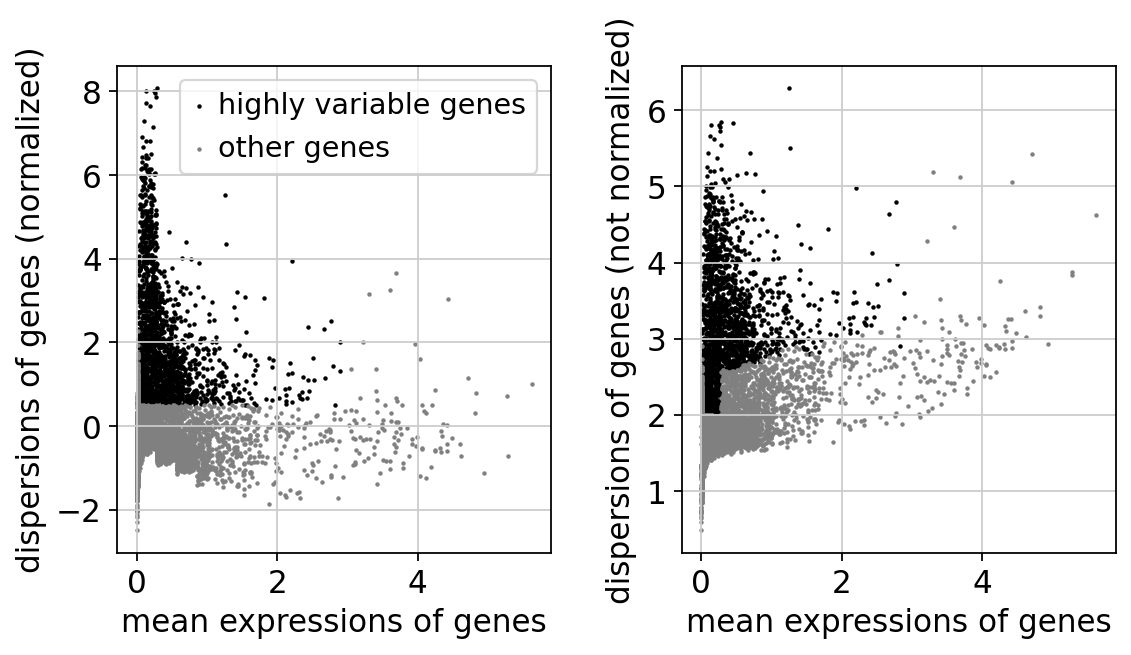

In [14]:
# Identify highly-variable genes.
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

In [15]:
# Set the .raw attribute of the AnnData object to the normalized 
# and logarithmized raw gene expression for later use in differential 
# testing and visualizations of gene expression. This simply freezes the state of the AnnData object.
adata.raw = adata

In [16]:
# Now filtered out the data based on highly variable genes
adata = adata[:, adata.var.highly_variable]

In [17]:
# Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. 
# Scale the data to unit variance.
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:07)


In [18]:
sc.pp.scale(adata, max_value=10)

In [19]:
# PCA
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


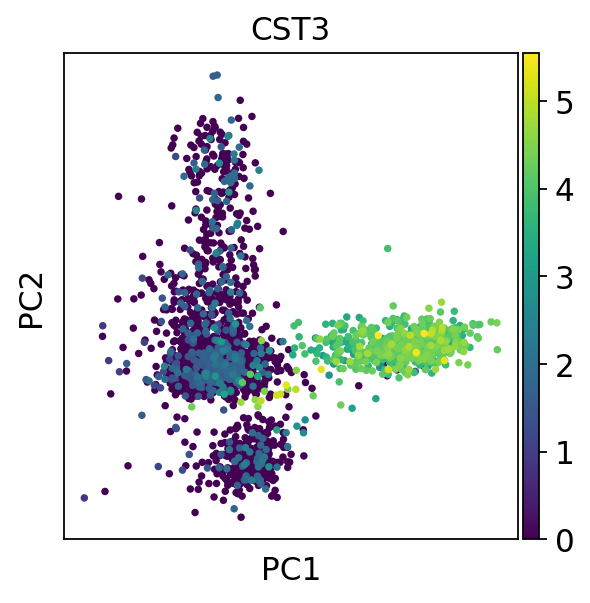

In [20]:
sc.pl.pca(adata, color='CST3')

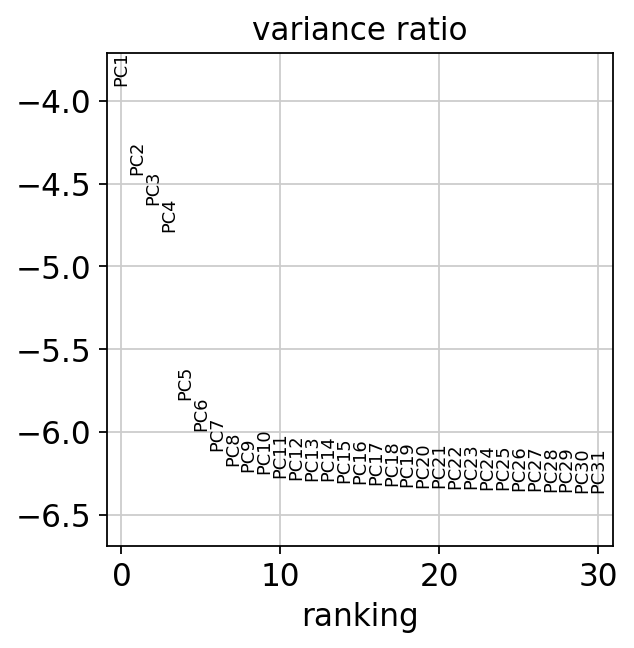

In [21]:
sc.pl.pca_variance_ratio(adata, log=True)

In [22]:
adata.write(results_file)

In [23]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [24]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)


In [25]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)


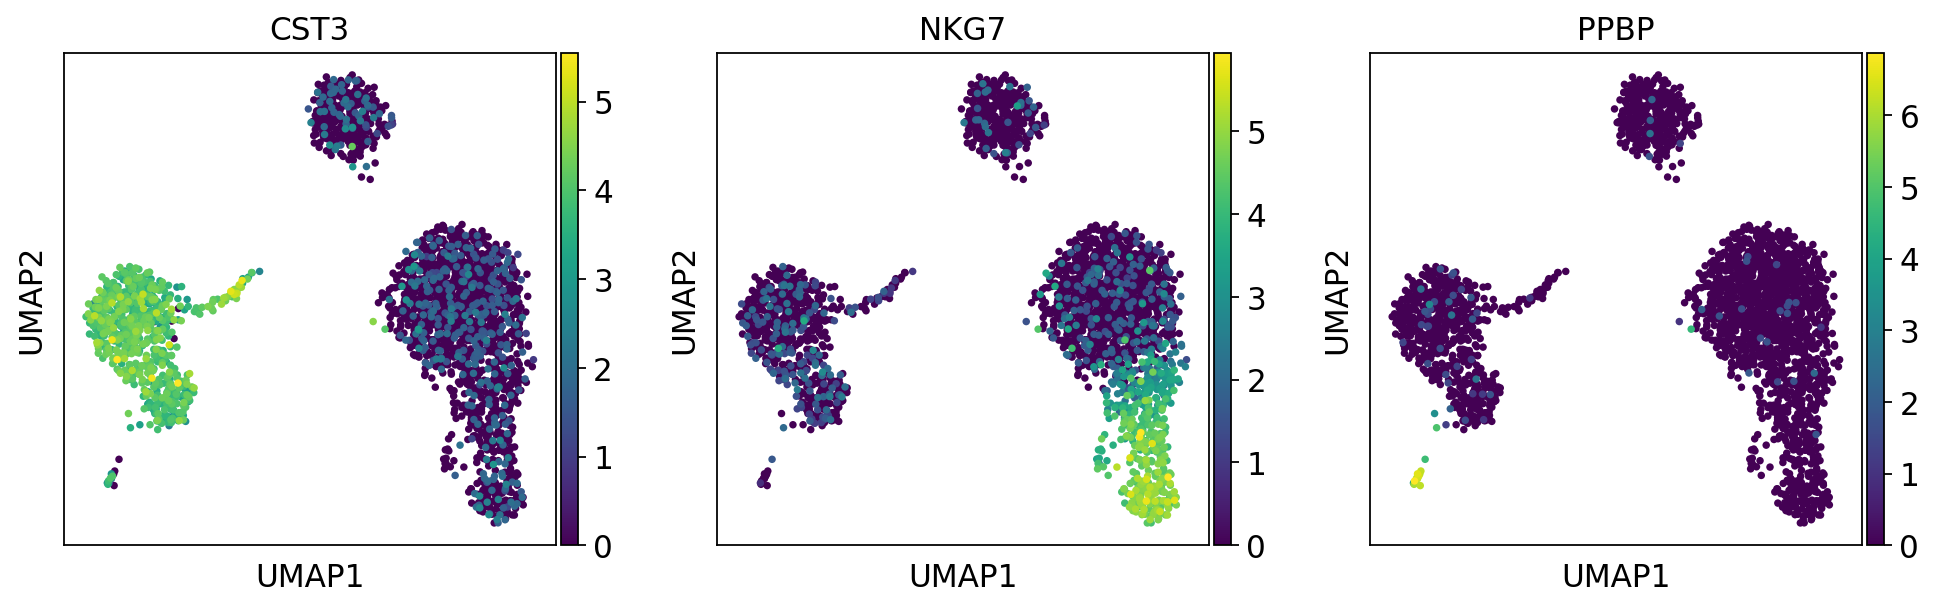

In [26]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'])

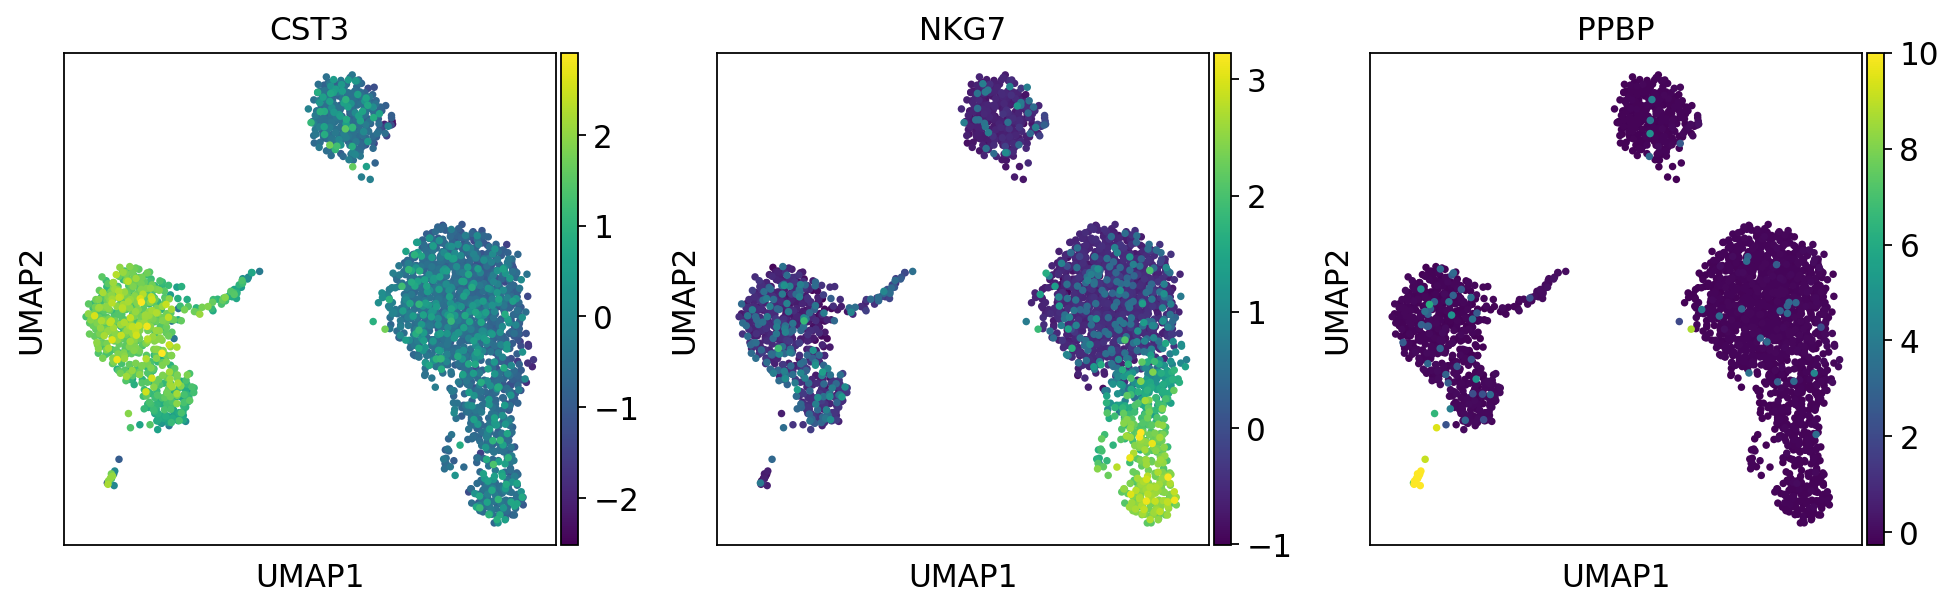

In [27]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'], use_raw=False)

In [28]:
sc.tl.leiden(adata)
#sc.tl.louvain(adata)

running Leiden clustering
    finished: found 9 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


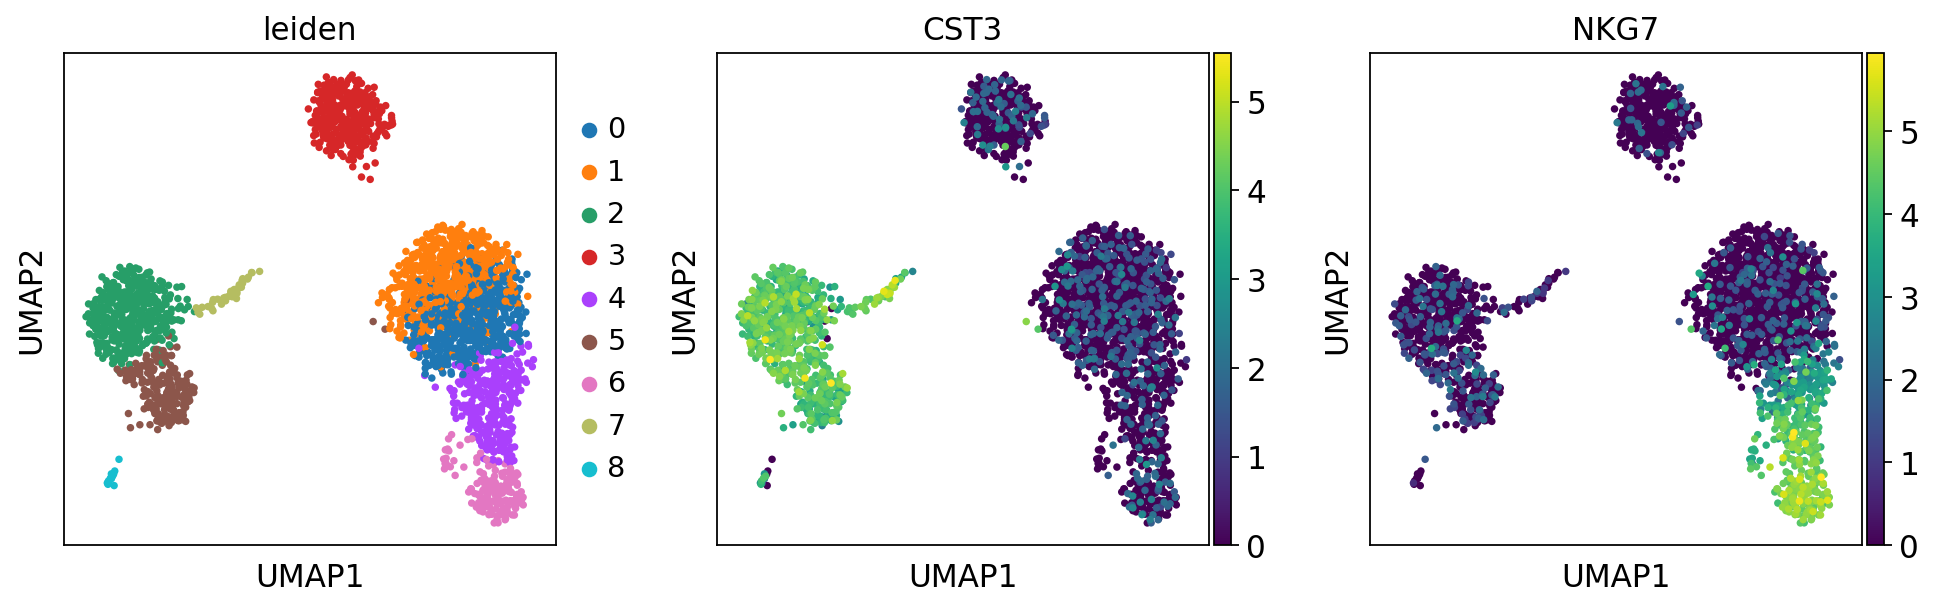

In [29]:
sc.pl.umap(adata, color=['leiden', 'CST3', 'NKG7'])

In [30]:
# save the results
adata.write(results_file)

In [31]:
#adata = sc.read(results_file)

### Differently expressed genes (DEGs)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


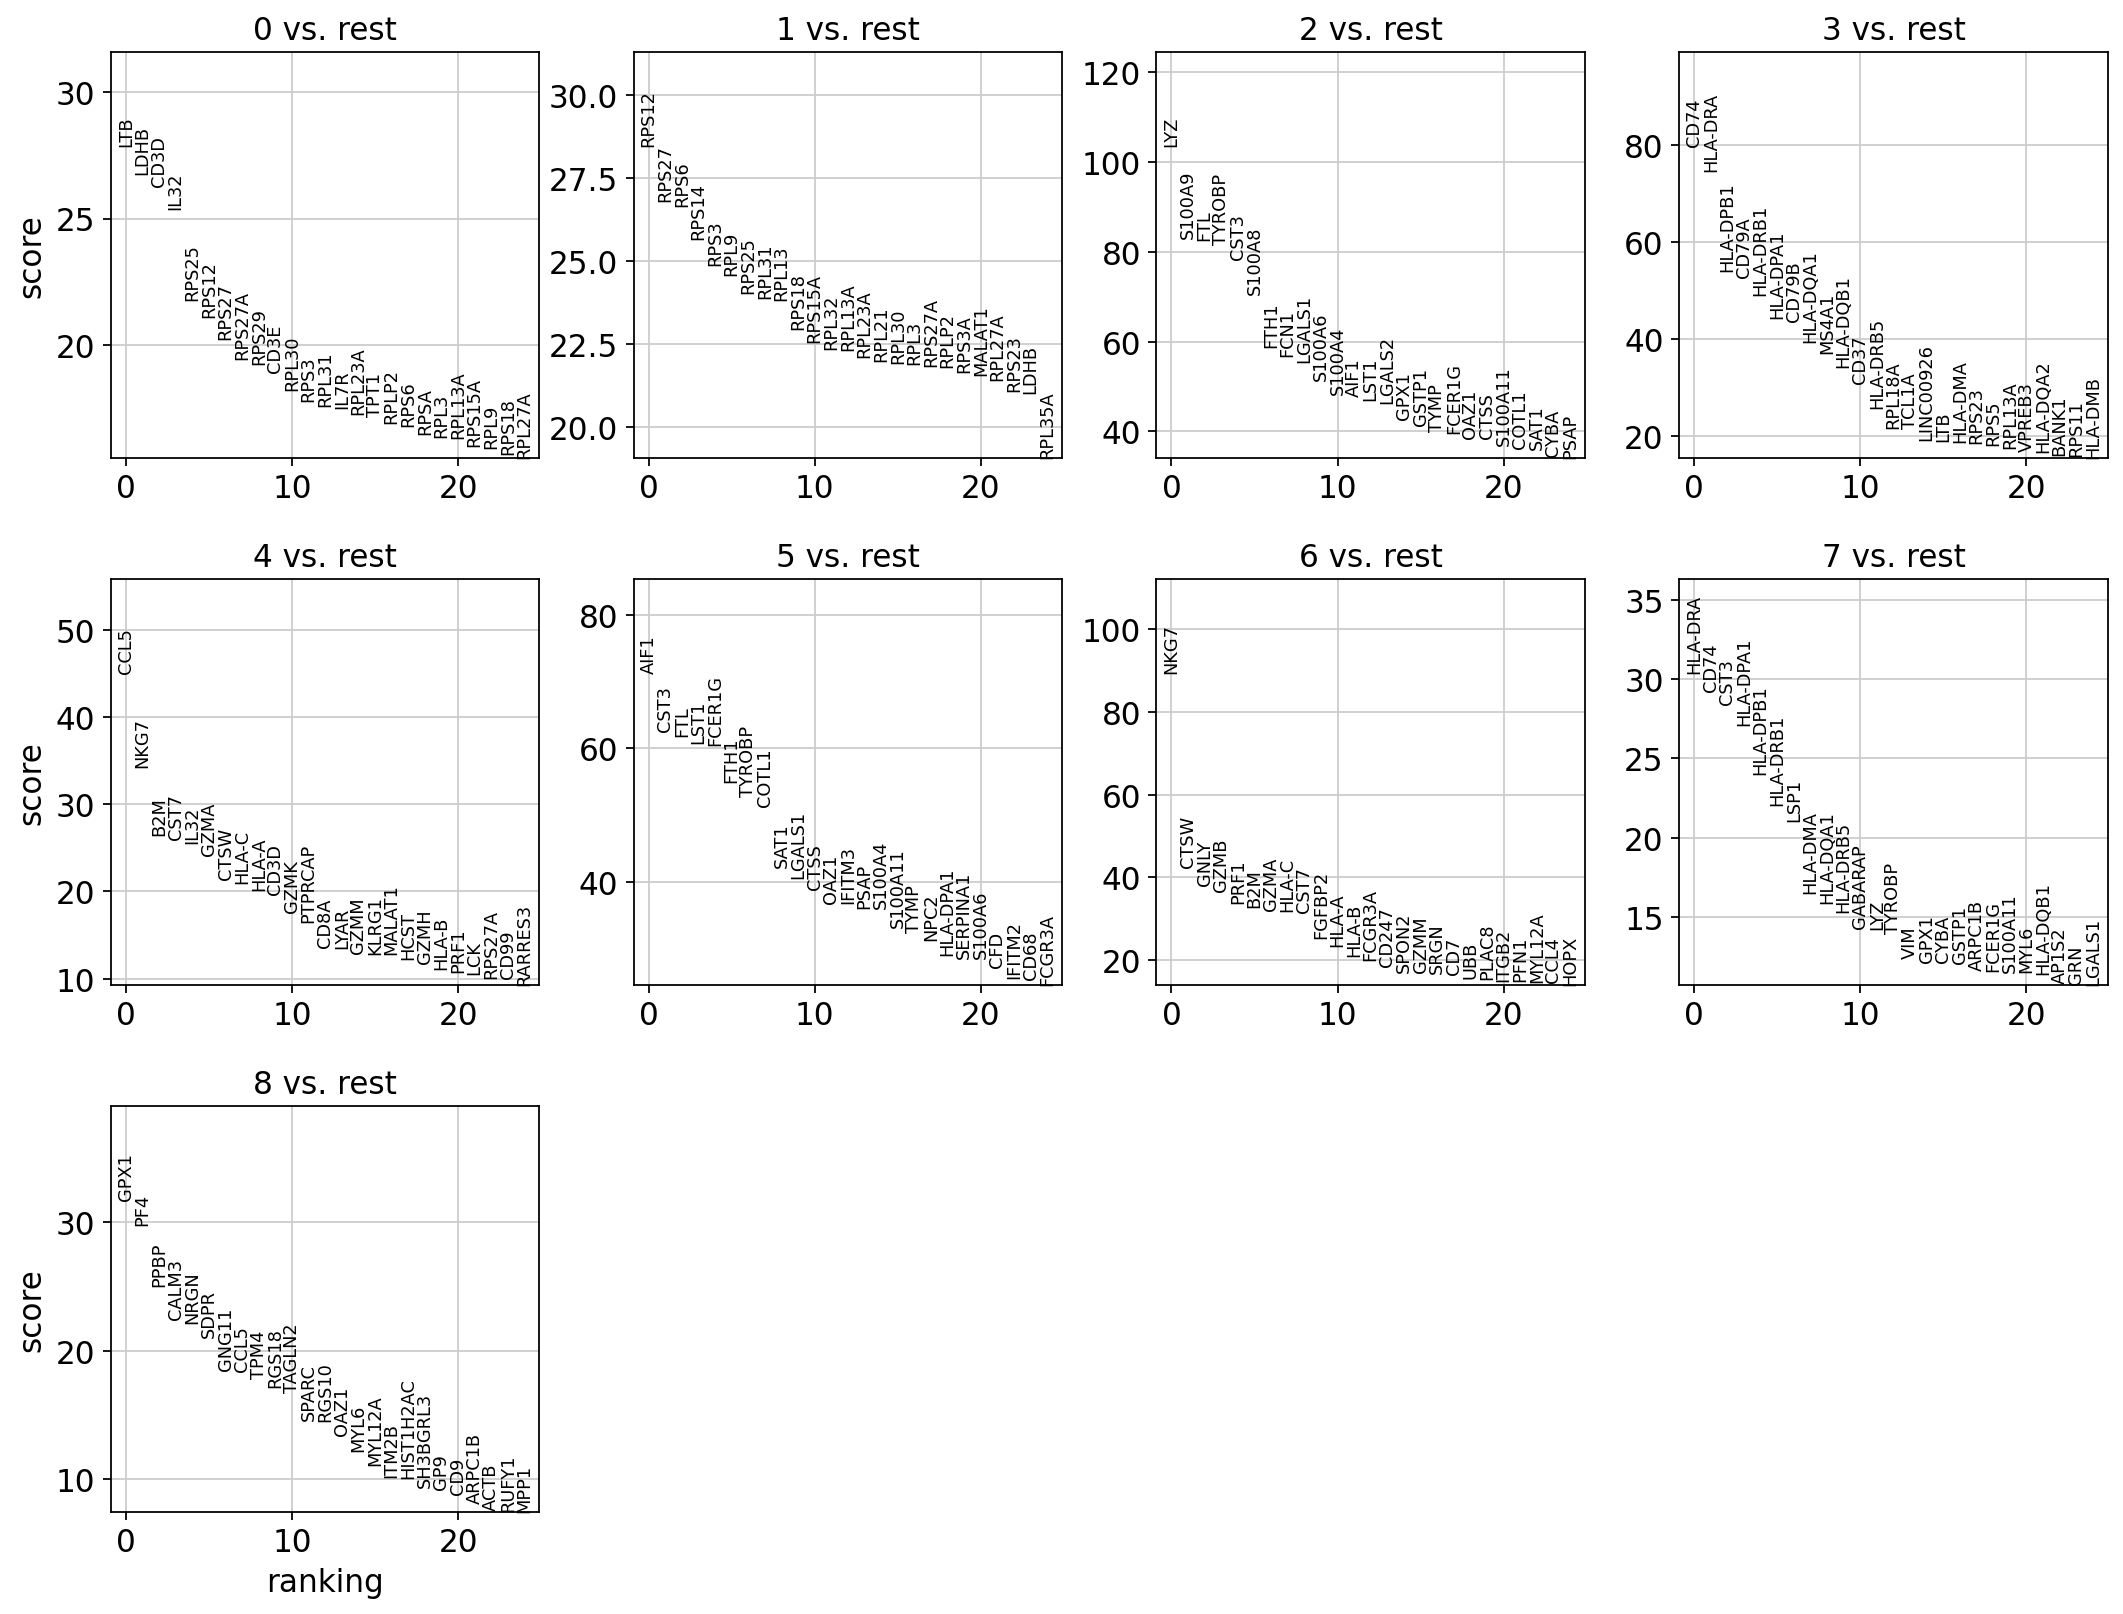

In [32]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [33]:
sc.settings.verbosity = 2  # reduce the verbosity

ranking genes
    finished (0:00:05)


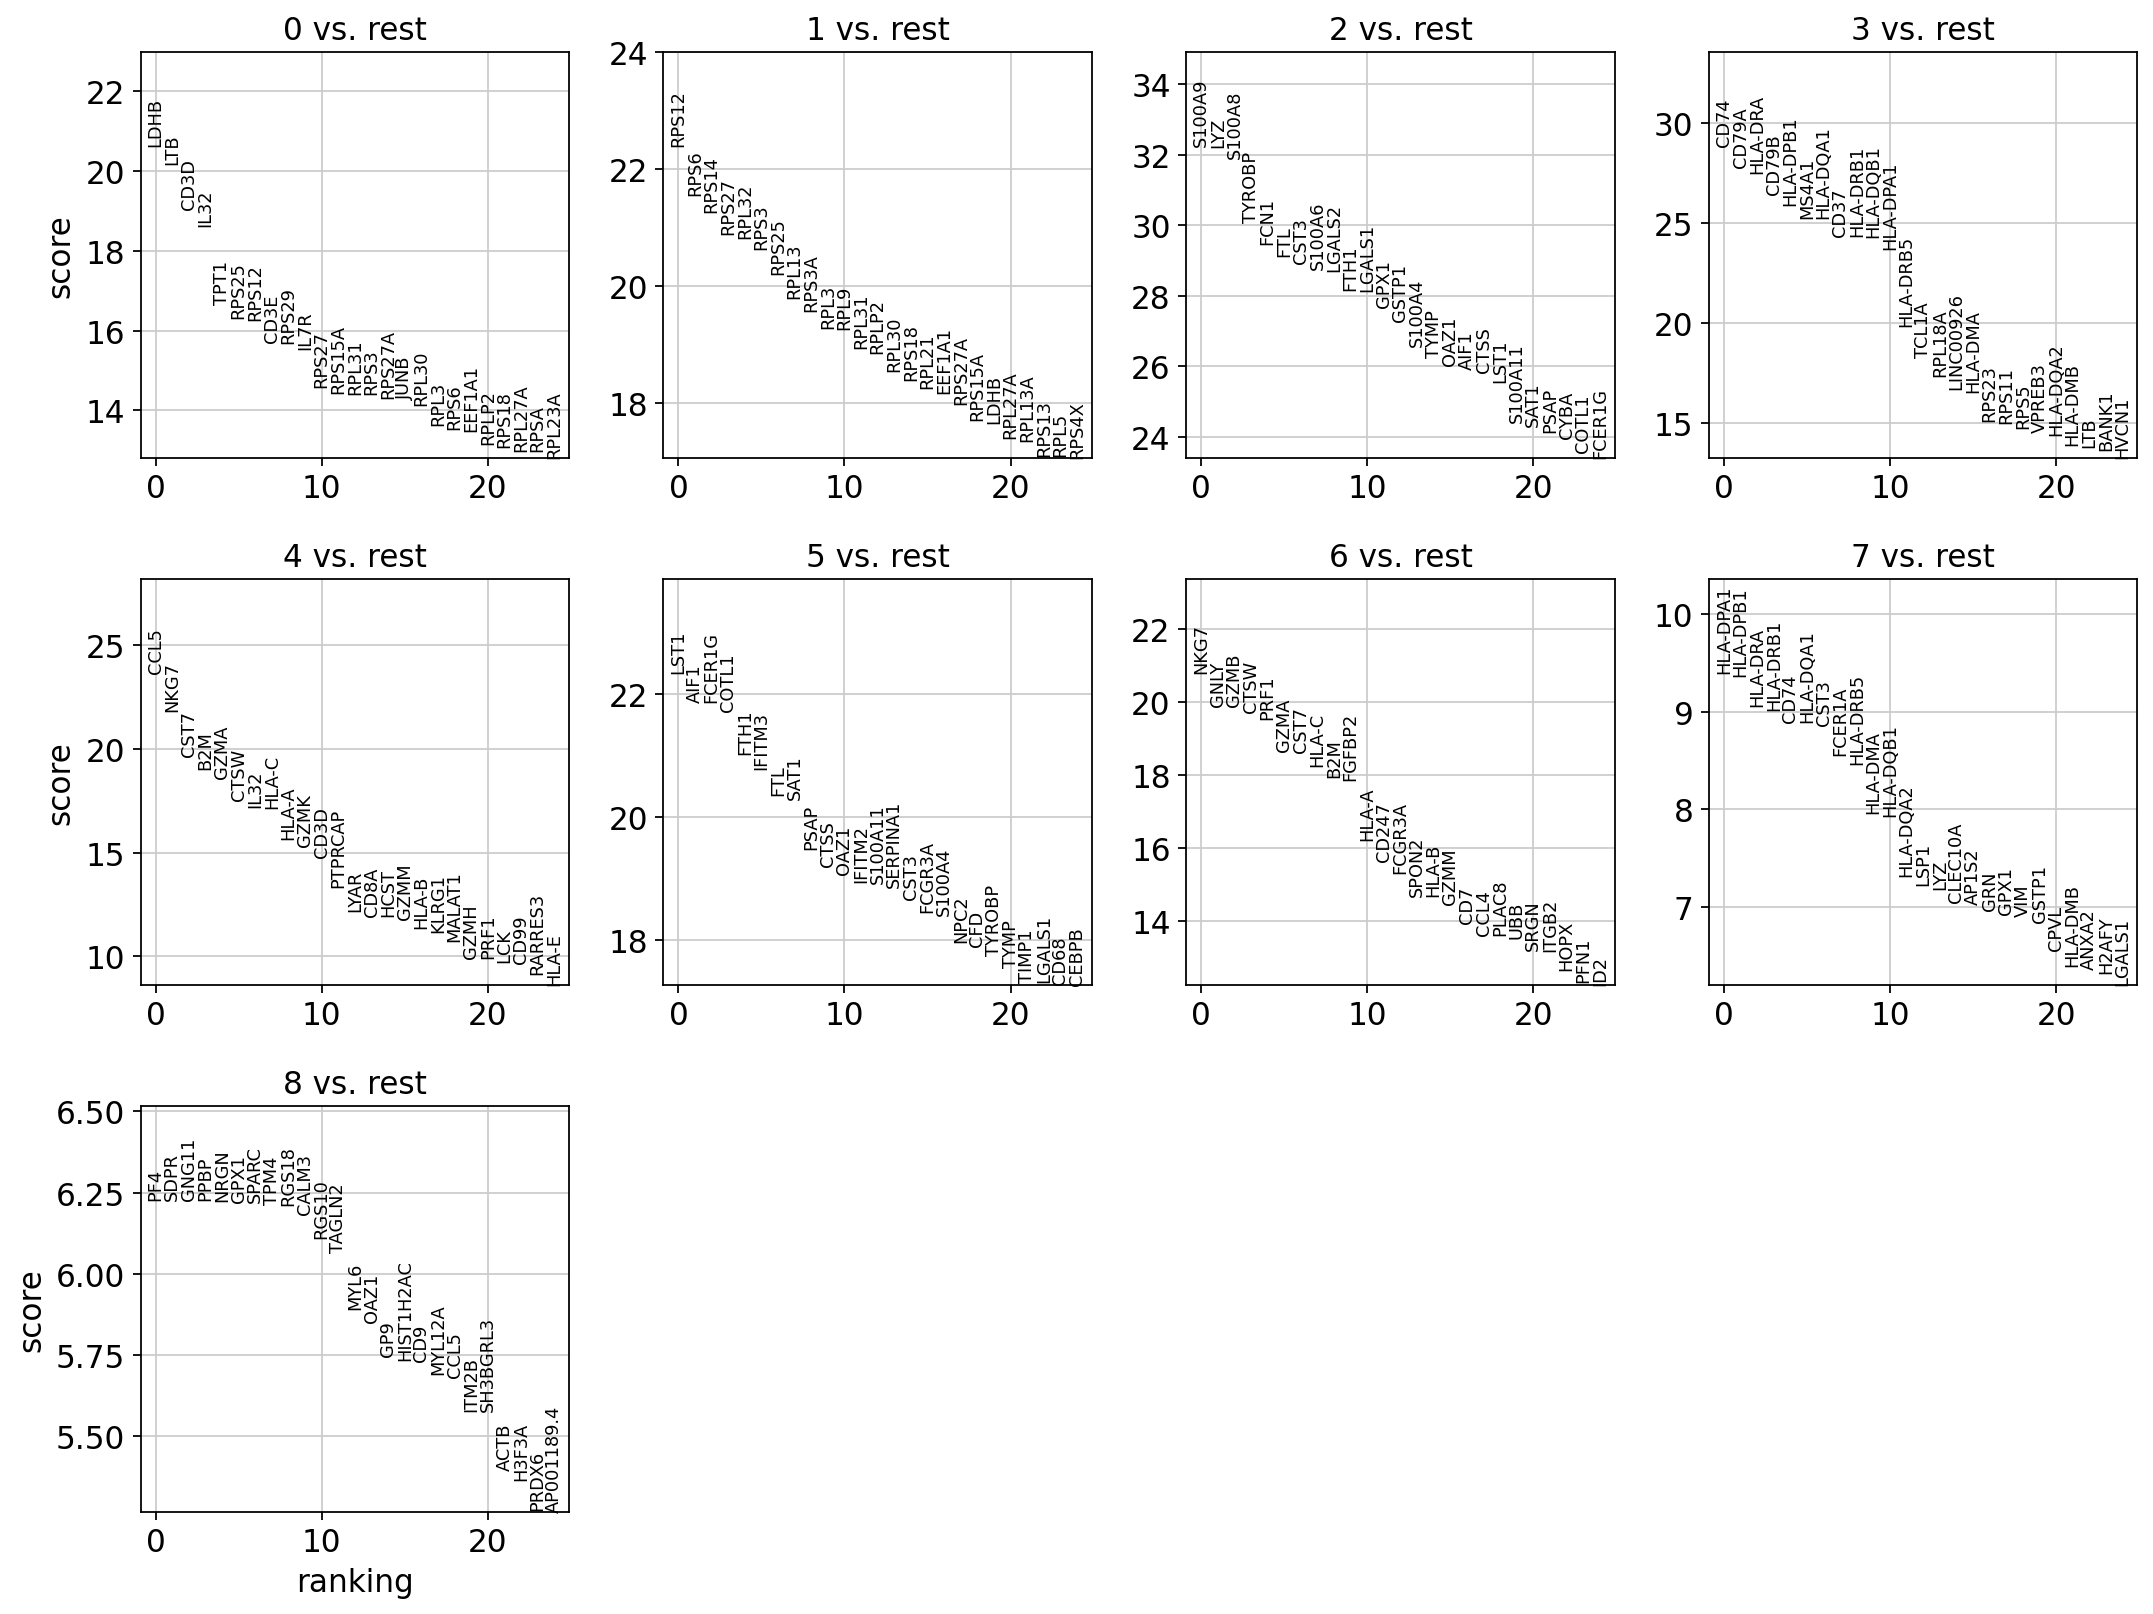

In [34]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [35]:
adata.write(results_file)

In [36]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

In [37]:
# Show the 10 top ranked genes per cluster 0, 1, …, 7 in a dataframe.
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

,0,1,2,3,4,5,6,7,8
0,LDHB,RPS12,S100A9,CD74,CCL5,LST1,NKG7,HLA-DPA1,PF4
1,LTB,RPS6,LYZ,CD79A,NKG7,AIF1,GNLY,HLA-DPB1,SDPR
2,CD3D,RPS14,S100A8,HLA-DRA,CST7,FCER1G,GZMB,HLA-DRA,GNG11
3,IL32,RPS27,TYROBP,CD79B,B2M,COTL1,CTSW,HLA-DRB1,PPBP
4,TPT1,RPL32,FCN1,HLA-DPB1,GZMA,FTH1,PRF1,CD74,NRGN


In [38]:
# Get a table with the scores and groups.
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p,5_n,5_p,6_n,6_p,7_n,7_p,8_n,8_p
0,LDHB,1.344679e-94,RPS12,3.837912e-111,S100A9,3.165481e-228,CD74,2.487145e-183,CCL5,7.406990e-124,LST1,1.441305e-110,NKG7,4.321025e-96,HLA-DPA1,5.422417e-21,PF4,4.722886e-10
1,LTB,1.610359e-90,RPS6,4.498800e-103,LYZ,1.222909e-227,CD79A,1.679730e-170,NKG7,1.248084e-105,AIF1,4.619523e-106,GNLY,4.640732e-88,HLA-DPB1,7.591860e-21,SDPR,4.733899e-10
2,CD3D,7.149230e-81,RPS14,1.984804e-100,S100A8,1.691910e-223,HLA-DRA,6.942399e-167,CST7,4.146166e-86,FCER1G,5.769499e-106,GZMB,5.208282e-88,HLA-DRA,1.306768e-19,GNG11,4.733899e-10
3,IL32,1.950599e-77,RPS27,5.513297e-97,TYROBP,6.141017e-199,CD79B,2.569135e-154,B2M,1.177237e-80,COTL1,1.441068e-104,CTSW,1.202514e-86,HLA-DRB1,1.865104e-19,PPBP,4.744938e-10
4,TPT1,2.624075e-62,RPL32,2.492617e-96,FCN1,7.968489e-191,HLA-DPB1,3.580735e-148,GZMA,2.292275e-77,FTH1,4.109356e-98,PRF1,5.056639e-85,CD74,5.853161e-19,NRGN,4.800511e-10


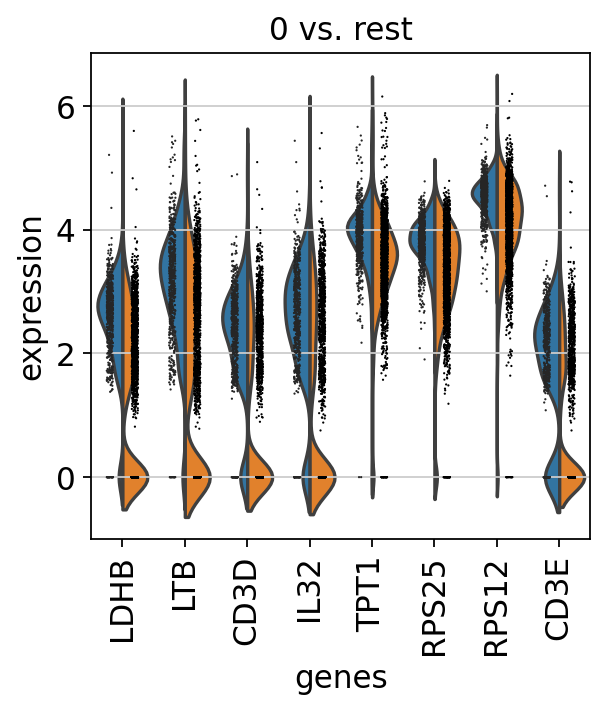

In [39]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

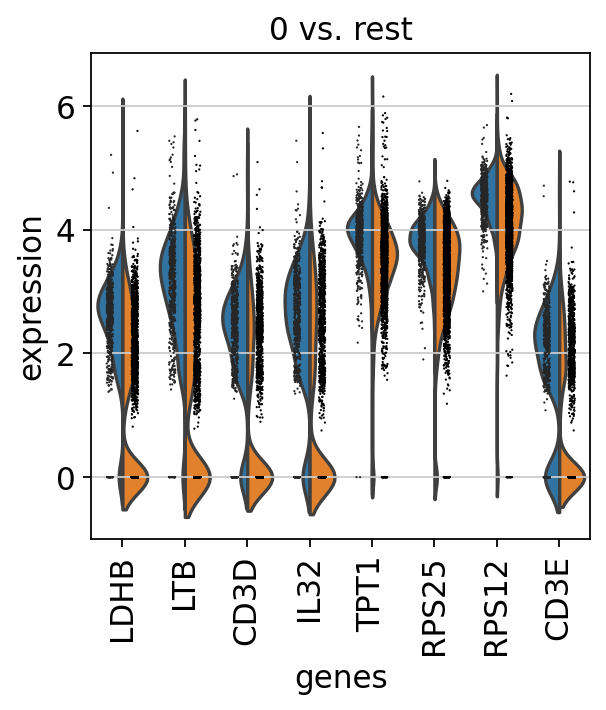

In [40]:
# Relaod the data and make comparison with other groups
adata = sc.read(results_file)
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

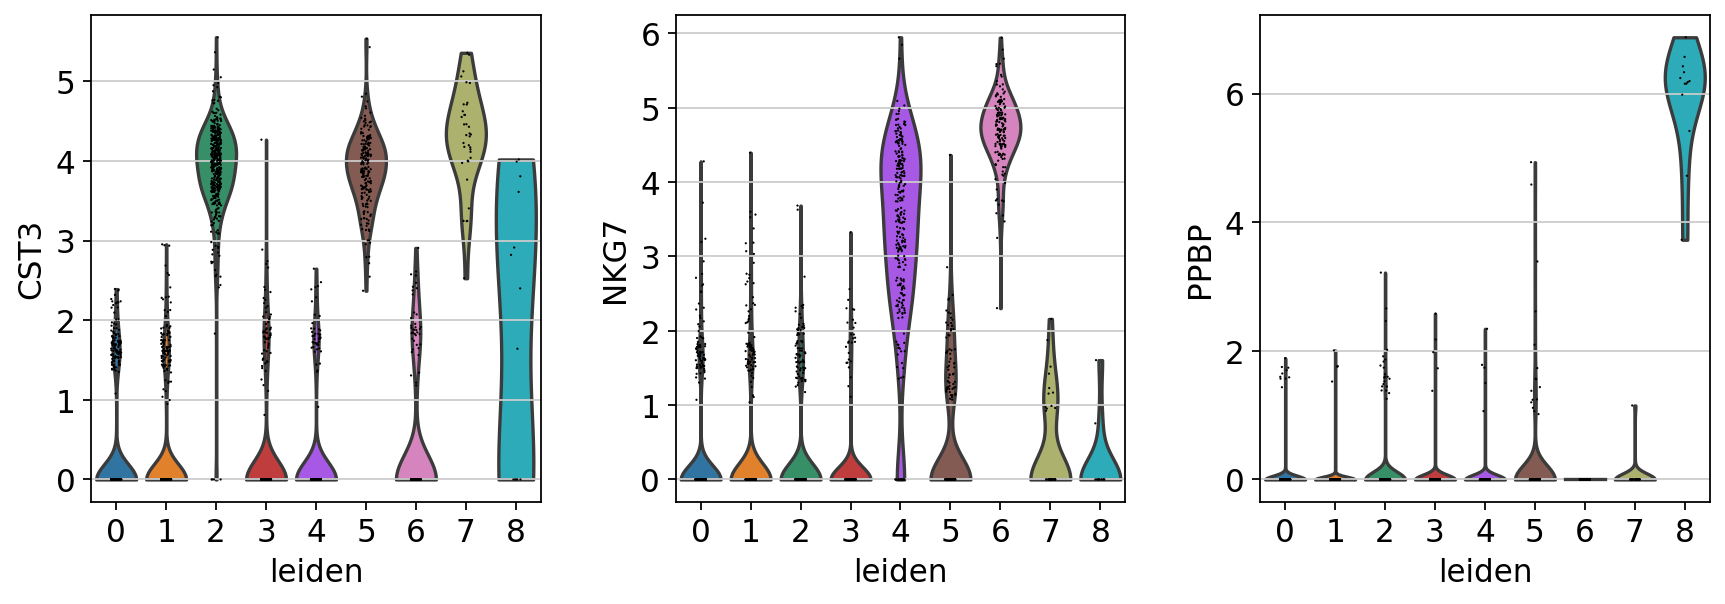

In [41]:
# you can also compare a certain gene across groups
sc.pl.violin(adata, ['CST3', 'NKG7', 'PPBP'], groupby='leiden')

### Name clusters based on marker genes

In [42]:
adata = sc.read(results_file)

new_cluster_names = [
    'CD4 T', 'Naive CD4 T', 'CD14 Monocytes',
    'B', 'CD8 T',
    'NK', 'FCGR3A Monocytes',
    'Dendritic', 'Megakaryocytes']
adata.rename_categories('leiden', new_cluster_names)

/opt/conda/envs/scGen/lib/python3.8/site-packages/anndata/_core/anndata.py:1160: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  self.obs[key].cat.rename_categories(categories, inplace=True)


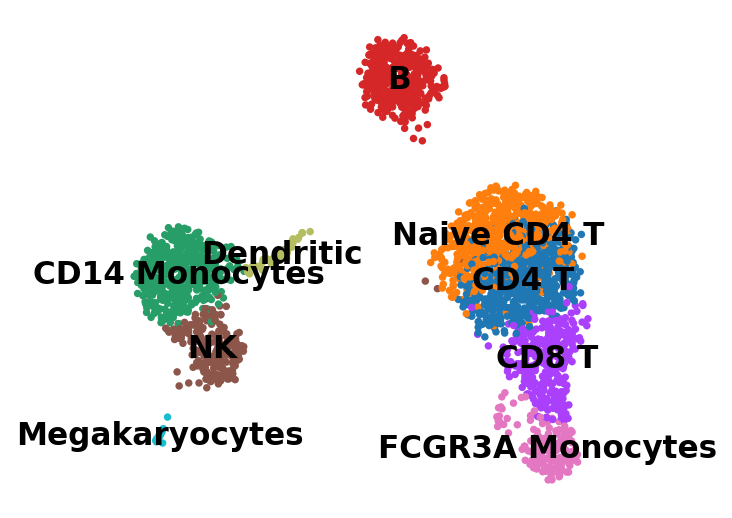

In [43]:
sc.pl.umap(adata, color='leiden', legend_loc='on data', title='', frameon=False, save='.pdf')

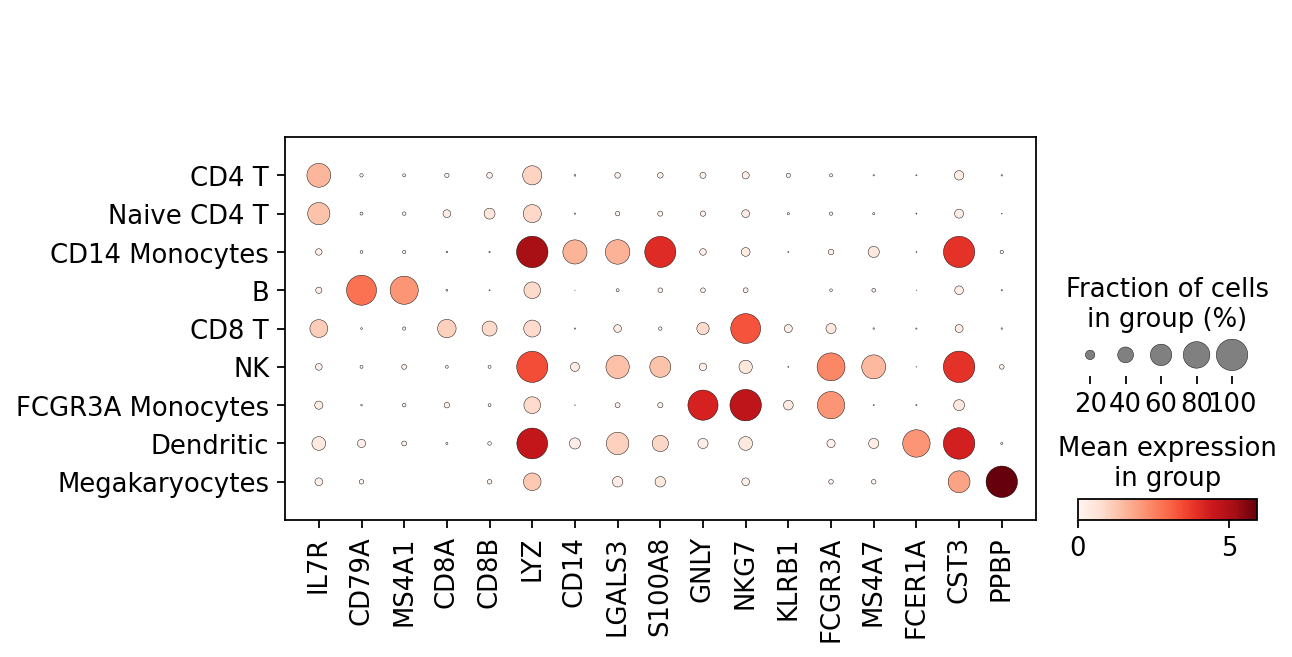

In [44]:
sc.pl.dotplot(adata, marker_genes, groupby='leiden')

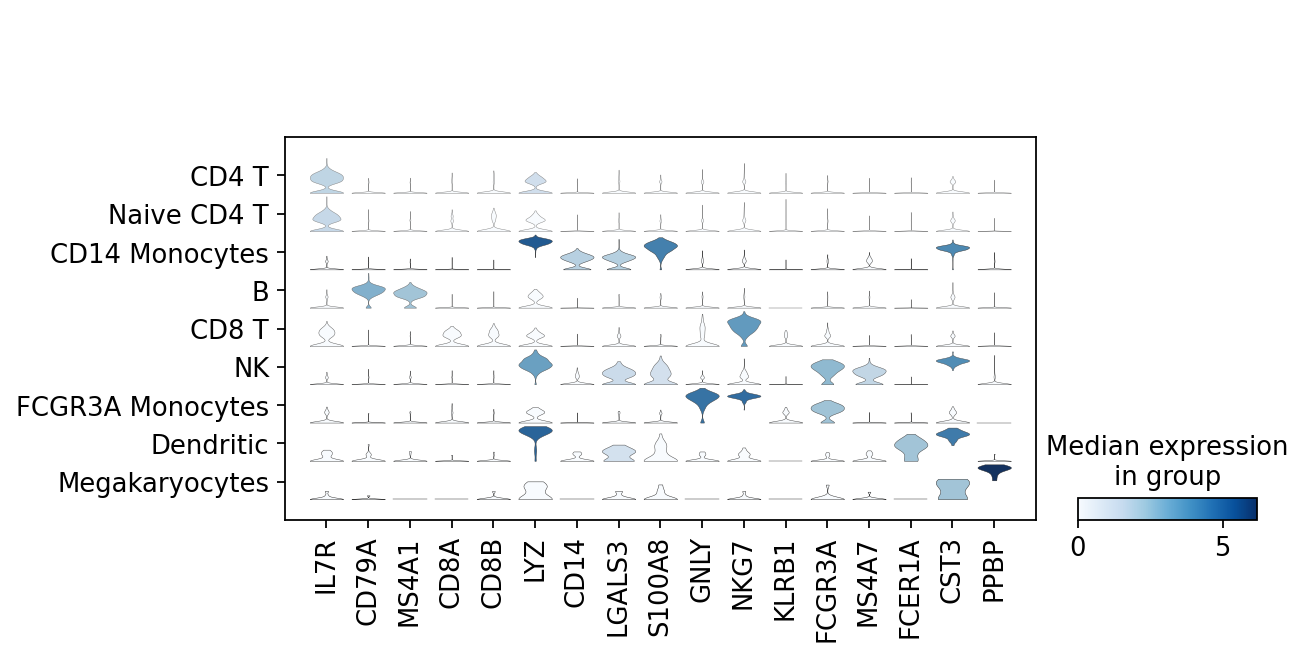

In [45]:
sc.pl.stacked_violin(adata, marker_genes, groupby='leiden', rotation=90)

In [46]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [47]:
#adata.write(results_file, compression='gzip')  # `compression='gzip'` saves disk space, but slows down writing and subsequent reading

running PAGA
    finished (0:00:00)


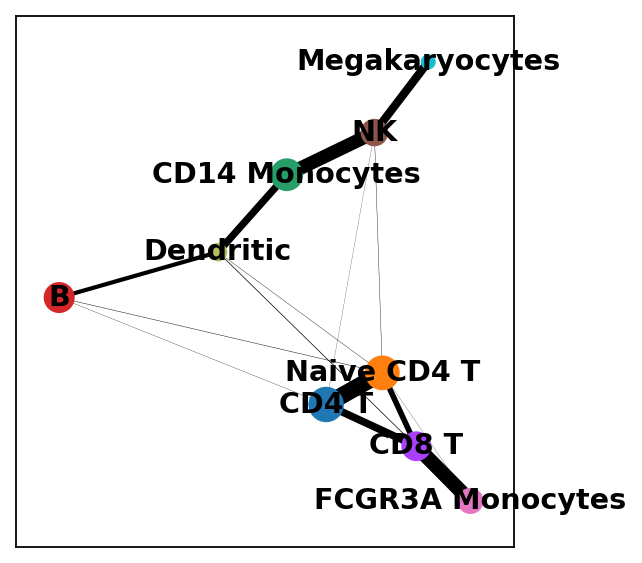

computing UMAP
    finished (0:00:04)


In [48]:
# PAGA graph constructed on the leiden graphs
sc.tl.paga(adata)
sc.pl.paga(adata)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata, init_pos='paga')